In [235]:
import pulp

In [236]:

soc = [30,30,30]
n = len(soc)
stations = [20,30,50,40,100]
#stations = [90,120,150]
speed = 10
charging_rate_station = 5
ex_charging_rate_bess = 5
arrival_time = [1,2,3]
T = 1000
bess_capacity = 300
bess_init = [100,120,100,100,100]
kms_to_soc = 1
for i in range(len(stations)):
    stations[i]=stations[i]*kms_to_soc
speed = speed*kms_to_soc
print(speed)
print(stations)

time_discre = 1
for i in range(len(arrival_time)):
    arrival_time[i] *= time_discre
speed = speed/time_discre
charging_rate_station = charging_rate_station/time_discre
ex_charging_rate_bess = ex_charging_rate_bess/time_discre


10
[20, 30, 50, 40, 100]


In [237]:
#initiate the model
cs = pulp.LpProblem("station",pulp.LpMinimize)
vehicles=[]
s_names = []
#add variables
soc_vehicle = {}
arrival_time_vehicle = {}
for i in range(n):
    vehicles.append(f"V{i}")
    soc_vehicle[f"V{i}"] = soc[i]
    arrival_time_vehicle[f"V{i}"] = arrival_time[i]
m = len(stations)-1
bess_init_name = {}
for i in range(m):
    s_names.append(f"station{i+1}")
    bess_init_name[f"station{i+1}"] = bess_init[i]
print(s_names)
print(bess_init_name)
M = 100000
print(vehicles)
a = {}
s = {}
u = {}
d = {}
o = {}
sb = {}
b = {}
bc = {}
charge = {}
bac = {}

for station in s_names:
    #arrival time at stations
    a[station] = pulp.LpVariable.dict(f"Arrival Time {station}",[vehicle for vehicle in vehicles],lowBound=0,upBound=T,cat=pulp.LpInteger)
    
    # servicing time at stations
    s[station] = pulp.LpVariable.dict(f"Service Time {station}",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
    
    #initial charging time at sations
    u[station] = pulp.LpVariable.dict(f"initial charge time {station}",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
    
    #final charge time at stations
    d[station] = pulp.LpVariable.dict(f"final charge time {station}",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
    
    # sigma- temporal ordering of vehicles
    o[station] = pulp.LpVariable.dict(f"sigma {station}",[vehicle1+vehicle2 for vehicle1 in vehicles for vehicle2 in vehicles if vehicle1 != vehicle2],lowBound=0,cat=pulp.LpBinary)
    
    # to see if vehicle is gonna use the respective station
    sb[station] = pulp.LpVariable.dict(f"Service Time {station} binary",[vehicle for vehicle in vehicles],cat=pulp.LpBinary)
    
    #bess servicing times at stations
    b[station] = pulp.LpVariable.dict(f"BESS service Time {station}",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
    
    # charge in bess available for vehicles
    bc[station] = pulp.LpVariable.dict(f"BESS charge {station}",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
    
    # if bess reached max charge or not
    charge[station] = pulp.LpVariable.dict(f"reached max charge {station}",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpBinary)
    
    #amount to charge
    bac[station] = pulp.LpVariable.dict(f"BESS charge for vehicle {station}",[vehicle for vehicle in vehicles],cat=pulp.LpInteger)
    
for i in range(len(s_names)):
    for vehicle in vehicles:
        if i == 0:
            cs += a[s_names[i]][vehicle] == arrival_time_vehicle[vehicle]+(stations[0]/speed)
        else:
            cs += a[s_names[i]][vehicle] == (stations[i]/speed) + d[s_names[i-1]][vehicle]
for vehicle in vehicles:
    cs += u[s_names[-1]][vehicle] <= T-s[s_names[-1]][vehicle]
dist = 0
for i in range(len(s_names)):
    dist += stations[i]
    for vehicle in vehicles:
        cs += charging_rate_station*(pulp.lpSum(s[s_names[j]][vehicle] for j in range(i+1)))+ex_charging_rate_bess*(pulp.lpSum(b[s_names[j]][vehicle] for j in range(i+1))) + soc_vehicle[vehicle] >= dist + stations[i+1]
        cs += charging_rate_station*(pulp.lpSum(s[s_names[j]][vehicle] for j in range(i+1)))+ex_charging_rate_bess*(pulp.lpSum(b[s_names[j]][vehicle] for j in range(i+1))) + soc_vehicle[vehicle] -dist <= 100
#constraints
for station in s_names:
    for vehicle in vehicles:
        
        #departure = service + charge start
        cs += d[station][vehicle] == s[station][vehicle]+u[station][vehicle]

        # charge start > arival time
        cs += u[station][vehicle]>=a[station][vehicle]

        #to see if a vehicle wants to cross the station or charge there
        cs += M*sb[station][vehicle] >=s[station][vehicle]
        cs += sb[station][vehicle] <= s[station][vehicle]
        
        # bess time should be less than total charging time at 
        cs += b[station][vehicle]<=s[station][vehicle]
        cs += b[station][vehicle]*ex_charging_rate_bess<=bc[station][vehicle]
        
        #checking if the amount we charge is greater than 100 or not
        cs += M*charge[station][vehicle]>=bess_init_name[station]+bac[station][vehicle]-bess_capacity
        cs += M*(1-charge[station][vehicle]) >= -(bess_init_name[station]+bac[station][vehicle]-bess_capacity)

        # implementing max of bess capaicty
        cs += bc[station][vehicle]>= bess_capacity - M*(1-charge[station][vehicle])
        cs += bc[station][vehicle]>= bess_init_name[station] + bac[station][vehicle] - M*(charge[station][vehicle])
        cs += bc[station][vehicle]<= bess_capacity + M*(1-charge[station][vehicle])
        cs += bc[station][vehicle]<= bess_init_name[station] + bac[station][vehicle] + M*(charge[station][vehicle])  
            
    # for bess implementations
    for station in s_names:
        for i in range(len(vehicles)):
            #calculating how much charge is available for a vehicle in the bess
            cs += bac[station][vehicles[i]] ==  (u[station][vehicles[i]]-u[station][vehicles[0]] - 2*pulp.lpSum([b[station][vehicles[j]]] for j in range(i-1,-1,-1)))*ex_charging_rate_bess    # for waiting time implementation 
        for vehicle1 in vehicles:
            for vehicle2 in vehicles:
                if vehicle1!=vehicle2:
                    
                    #making sure o1[vehicle1+vehicle2] = 1 when vehicle1 in front of vehicle2
                    cs += M*o[station][vehicle1+vehicle2] >= a[station][vehicle2]-a[station][vehicle1]
                    cs += M*(1-o[station][vehicle1+vehicle2])>= a[station][vehicle1]-a[station][vehicle2]
                    
                    #implementing wait time
                    cs += u[station][vehicle2]-u[station][vehicle1]-s[station][vehicle1]>=(o[station][vehicle1+vehicle2]-1)*T-M*(1-sb[station][vehicle2])                
                    
                    #making sure only one vehicle is front of another
                    cs += o[station][vehicle1+vehicle2] + o[station][vehicle2+vehicle1] >= 1


['station1', 'station2', 'station3', 'station4']
{'station1': 100, 'station2': 120, 'station3': 100, 'station4': 100}
['V0', 'V1', 'V2']


In [238]:
cs

station:
MINIMIZE
None
SUBJECT TO
_C1: Arrival_Time_station1_V0 = 3

_C2: Arrival_Time_station1_V1 = 4

_C3: Arrival_Time_station1_V2 = 5

_C4: Arrival_Time_station2_V0 - final_charge_time_station1_V0 = 3

_C5: Arrival_Time_station2_V1 - final_charge_time_station1_V1 = 3

_C6: Arrival_Time_station2_V2 - final_charge_time_station1_V2 = 3

_C7: Arrival_Time_station3_V0 - final_charge_time_station2_V0 = 5

_C8: Arrival_Time_station3_V1 - final_charge_time_station2_V1 = 5

_C9: Arrival_Time_station3_V2 - final_charge_time_station2_V2 = 5

_C10: Arrival_Time_station4_V0 - final_charge_time_station3_V0 = 4

_C11: Arrival_Time_station4_V1 - final_charge_time_station3_V1 = 4

_C12: Arrival_Time_station4_V2 - final_charge_time_station3_V2 = 4

_C13: Service_Time_station4_V0 + initial_charge_time_station4_V0 <= 1000

_C14: Service_Time_station4_V1 + initial_charge_time_station4_V1 <= 1000

_C15: Service_Time_station4_V2 + initial_charge_time_station4_V2 <= 1000

_C16: 5 BESS_service_Time_station

In [239]:
cs += pulp.lpSum([d[station][vehicle]-a[station][vehicle]] for station in s_names for vehicle in vehicles)
cs.solve()

pulp.LpStatus[cs.status]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/sushi/Desktop/internship/Routing/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6fae1ed38b764839a009d447cf699e5d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/6fae1ed38b764839a009d447cf699e5d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 620 COLUMNS
At line 2804 RHS
At line 3420 BOUNDS
At line 3553 ENDATA
Problem MODEL has 615 rows, 132 columns and 1879 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 63 - 0.00 seconds
Cgl0003I 3 fixed, 75 tightened bounds, 53 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 19 tightened bounds, 26 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 188 rows, 96 columns (96 integer (35 of which binary)) and 558 e

'Optimal'

wait and charging time is  72.0
[[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 1.0], [4.0, 0.0, 2.0, 0.0]]


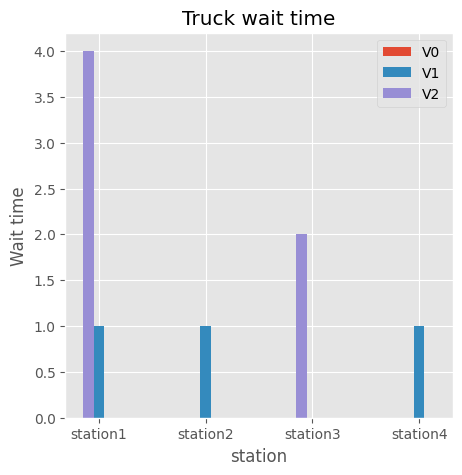

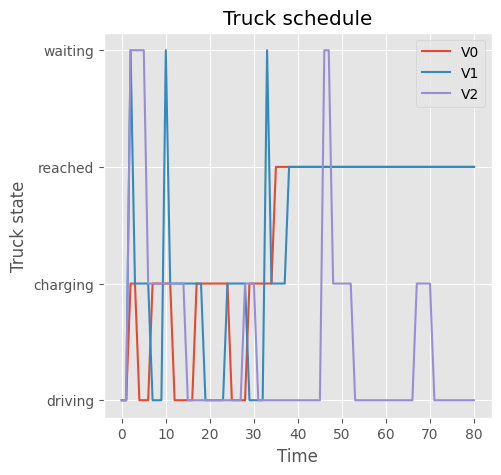

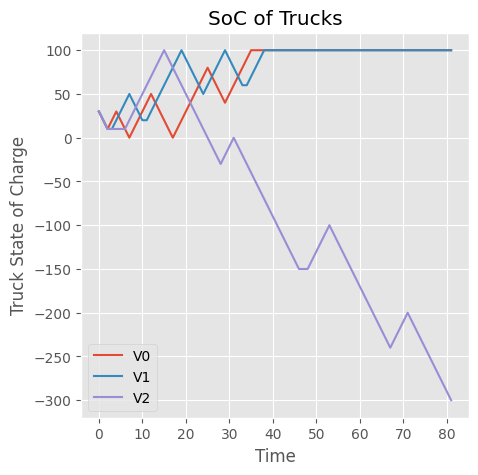

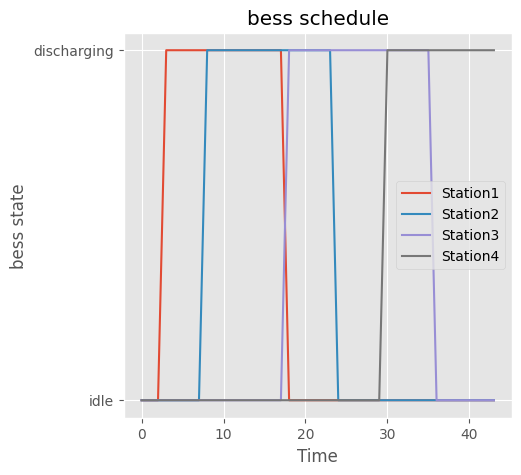

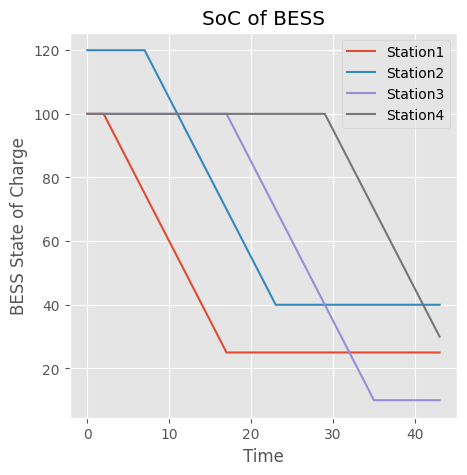

'for vehicle in vehicles:\n    print_str = ""\n    for i in range((20-len(vehicle))//2):\n        print_str +=" "\n    for i in range((len(vehicle))):\n        print_str += vehicle[i]\n    if (20-len(vehicle))%2==0:\n        for i in range((20-len(vehicle))//2):\n            print_str +=" "\n    else:\n        for i in range((20-len(vehicle))//2+1):\n            print_str +=" "\n    print_str += "|"\n    \n    l = list(str(arrival_time_vehicle[vehicle]))\n    for i in range((12-len(l))//2):\n        print_str +=" "\n    for i in range(len(l)):\n        print_str += l[i]\n    if (12-len(l))%2==0:\n        for i in range((12-len(l))//2):\n            print_str +=" "\n    else:\n        for i in range((12-len(l))//2+1):\n            print_str +=" "\n        \n    print_str += "|"\n    #print(print_str)\n    l = list(str(int(a1[vehicle].varValue)))\n    for i in range((19-len(l))//2):\n        print_str +=" "\n    for i in range(len(l)):\n        print_str += l[i]\n    if (19-len(l))%2==0:

In [240]:


#objective function
print("wait and charging time is ",pulp.value(cs.objective))

state = {}
for vehicle in vehicles:
    state[vehicle] = []
max_len = 0
for i in range(len(s_names)):
    for vehicle in vehicles:
        for l in range(int(stations[i]/speed)):
            state[vehicle].append("driving")
        for j in range(int(u[s_names[i]][vehicle].varValue-a[s_names[i]][vehicle].varValue)):
            state[vehicle].append("waiting")
        for k in range(int(s[s_names[i]][vehicle].varValue)):
            state[vehicle].append("charging")
    for l in range(int(stations[-1]/speed)):
        state[vehicle].append("driving")
    if len(state[vehicle])>max_len:
        max_len = len(state[vehicle])
for vehicle in vehicles:
    if len(state[vehicle]) < max_len:
        for l in range(max_len-len(state[vehicle])):
            state[vehicle].append("reached")


# state is first graph variable     max_ len is max time       
            
soc_trucks = {}
max_len_soc = 0
for vehicle in vehicles:
    soc_trucks[vehicle] = [soc_vehicle[vehicle]]
for i in range(len(s_names)):
    for vehicle in vehicles:
        for j in range(int(stations[i]/speed)):
            soc_trucks[vehicle].append(soc_trucks[vehicle][-1]-speed)
        for j in range(int(u[s_names[i]][vehicle].varValue-a[s_names[i]][vehicle].varValue)):
            soc_trucks[vehicle].append(soc_trucks[vehicle][-1])
        for k in range(int(b[s_names[i]][vehicle].varValue)):
            soc_trucks[vehicle].append(soc_trucks[vehicle][-1]+ex_charging_rate_bess+charging_rate_station)
        for j in range(int(s[s_names[i]][vehicle].varValue-b[s_names[i]][vehicle].varValue)):
            soc_trucks[vehicle].append(soc_trucks[vehicle][-1]+charging_rate_station)
    for j in range(int(stations[-1]/speed)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]-speed)
    if len(soc_trucks[vehicle])>max_len_soc:
        max_len_soc = len(soc_trucks[vehicle])
for vehicle in vehicles:
    if len(soc_trucks[vehicle]) < max_len_soc:
        for j in range(max_len_soc-len(soc_trucks[vehicle])):
            soc_trucks[vehicle].append(soc_trucks[vehicle][-1])
soc_bess = []
bess_state = []
for i in range(len(s_names)):
    soc_bess.append([bess_init[i]])
    bess_state.append([])
for i  in range(len(s_names)):
    for j  in range(len(vehicles)):
        if j == 0:
            for k in range(int(u[s_names[i]][vehicles[j]].varValue)):
                bess_state[i].append("idle")
                soc_bess[i].append(soc_bess[i][-1])
            for k in range(int(b[s_names[i]][vehicles[j]].varValue)):
                bess_state[i].append("discharging")
                soc_bess[i].append(soc_bess[i][-1]-ex_charging_rate_bess)
            for k in range(int(s[s_names[i]][vehicles[j]].varValue-b[s_names[i]][vehicles[j]].varValue)):
                if soc_bess[i][-1] >= bess_capacity:
                    bess_state[i].append("idle")
                    soc_bess[i].append(soc_bess[i][-1])
                else:
                    bess_state[i].append("charging")
                    soc_bess[i].append(min(bess_capacity,soc_bess[i][-1]+ex_charging_rate_bess))
        else:
            for k in range(int(u[s_names[i]][vehicles[j]].varValue-u[s_names[i]][vehicles[j-1]].varValue-b[s_names[i]][vehicles[j-1]].varValue)):
                if soc_bess[i][-1] >= bess_capacity:
                    bess_state[i].append("idle")
                    soc_bess[i].append(soc_bess[i][-1])
                else:
                    bess_state[i].append("charging")
                    soc_bess[i].append(min(bess_capacity,soc_bess[i][-1]+ex_charging_rate_bess))
            for k in range(int(b[s_names[i]][vehicles[j]].varValue)):
                bess_state[i].append("discharging")
                soc_bess[i].append(soc_bess[i][-1]-ex_charging_rate_bess)
            for k in range(int(s[s_names[i]][vehicles[j]].varValue-b[s_names[i]][vehicles[j]].varValue)):
                if soc_bess[i][-1] >= bess_capacity:
                    bess_state[i].append("idle")
                    soc_bess[i].append(soc_bess[i][-1])
                else:
                    bess_state[i].append("charging")
                    soc_bess[i].append(min(bess_capacity,soc_bess[i][-1]+ex_charging_rate_bess))
                    
for vehicle in vehicles:
    if len(state[vehicle]) < max_len:
        for i in range(max_len-len(state[vehicle])):
            state[vehicle].append("reached")
max_len_bess = 0
for i in range(len(s_names)):
    max_len_bess = max(max_len_bess,len(soc_bess[i]))
for i in range(len(soc_bess)):
    for j in range(max_len_bess-len(soc_bess[i])):
        bess_state[i].append("idle")
        soc_bess[i].append(soc_bess[i][-1])
for i in range(len(s_names)):
    soc_bess[i].pop(0)

wait_time = {}
for vehicle in  vehicles:
    wait_time[vehicle] = []
for vehicle in vehicles:
    for station in s_names:
        wait_time[vehicle].append((u[station][vehicle].varValue-a[station][vehicle].varValue)/time_discre)


import seaborn as sns
import matplotlib.pyplot as plt

plot = [[] for i in range(len(vehicles))]
for i in range(len(vehicles)):
    plot[i]=wait_time[vehicles[i]]
print(plot)




import numpy as np  
import matplotlib.pyplot as plt  
X =s_names[:]
plt.figure(figsize=(5,5))  
X_axis = np.arange(len(X)) 
for i in range(len(vehicles)):
    plt.bar(X_axis - 0.1*(i-(len(vehicles)//2)), plot[i], 0.1, label = vehicles[i])
plt.xticks(X_axis, X) 
plt.xlabel("station") 
plt.ylabel("Wait time") 
plt.title("Truck wait time") 
plt.legend() 
plt.show() 


plt.figure(figsize=(5,5))
plt.style.use('ggplot')
# create data 
x = list(range(len(state[vehicles[0]])))
for i in range(len(x)):
    x[i] = x[i]/time_discre 
# plot lines 
for vehicle in vehicles:
    plt.plot(x, state[vehicle], label = vehicle) 
plt.xlabel("Time") 
plt.ylabel("Truck state") 
plt.title("Truck schedule") 
plt.legend() 
plt.show() 

plt.figure(figsize=(5,5))

x = list(range(max_len_soc))
for i in range(len(x)):
    x[i] = x[i]/time_discre

# plot lines 
for vehicle in vehicles:
    plt.plot(x, soc_trucks[vehicle], label = vehicle)
plt.xlabel("Time") 
plt.ylabel("Truck State of Charge") 
plt.title("SoC of Trucks")  
plt.legend() 
plt.show()

plt.figure(figsize=(5,5))
x = list(range(len(bess_state[0]))) 
for i in range(len(x)):
    x[i] = x[i]/time_discre
# plot lines 
for i in range(len(s_names)):
    plt.plot(x, bess_state[i], label = f"Station{i+1}") 
plt.xlabel("Time") 
plt.ylabel("bess state") 
plt.title("bess schedule") 
plt.legend() 
plt.show() 

plt.figure(figsize=(5,5))

x = list(range(len(soc_bess[0])))
for i in range(len(x)):
    x[i] = x[i]/time_discre
# plot lines 
for i in range(len(s_names)):
    plt.plot(x, soc_bess[i], label = f"Station{i+1}") 
plt.xlabel("Time") 
plt.ylabel("BESS State of Charge") 
plt.title("SoC of BESS")  
plt.legend() 
plt.show()

#print(" schedule of trucks | depot dept | station 1 arrival | charge start | charge end | station 1 dept | station 2 arrival | charge start | charge end | station 2 dept | arrival to destination |")
#print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
"""for vehicle in vehicles:
    print_str = ""
    for i in range((20-len(vehicle))//2):
        print_str +=" "
    for i in range((len(vehicle))):
        print_str += vehicle[i]
    if (20-len(vehicle))%2==0:
        for i in range((20-len(vehicle))//2):
            print_str +=" "
    else:
        for i in range((20-len(vehicle))//2+1):
            print_str +=" "
    print_str += "|"
    
    l = list(str(arrival_time_vehicle[vehicle]))
    for i in range((12-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (12-len(l))%2==0:
        for i in range((12-len(l))//2):
            print_str +=" "
    else:
        for i in range((12-len(l))//2+1):
            print_str +=" "
        
    print_str += "|"
    #print(print_str)
    l = list(str(int(a1[vehicle].varValue)))
    for i in range((19-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (19-len(l))%2==0:
        for i in range((19-len(l))//2):
            print_str +=" "
    else:
        for i in range((19-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u1[vehicle].varValue)))
    for i in range((14-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (14-len(l))%2==0:
        for i in range((14-len(l))//2):
            print_str +=" "
    else:
        for i in range((14-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u1[vehicle].varValue+s1[vehicle].varValue)))
    for i in range((12-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (12-len(l))%2==0:
        for i in range((12-len(l))//2):
            print_str +=" "
    else:
        for i in range((12-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u1[vehicle].varValue+s1[vehicle].varValue)))
    for i in range((16-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (16-len(l))%2==0:
        for i in range((16-len(l))//2):
            print_str +=" "
    else:
        for i in range((16-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(a2[vehicle].varValue)))
    for i in range((19-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (19-len(l))%2==0:
        for i in range((19-len(l))//2):
            print_str +=" "
    else:
        for i in range((19-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue)))
    for i in range((14-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (14-len(l))%2==0:
        for i in range((14-len(l))//2):
            print_str +=" "
    else:
        for i in range((14-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue+s2[vehicle].varValue)))
    for i in range((12-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (12-len(l))%2==0:
        for i in range((12-len(l))//2):
            print_str +=" "
    else:
        for i in range((12-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue+s2[vehicle].varValue)))
    for i in range((16-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (16-len(l))%2==0:
        for i in range((16-len(l))//2):
            print_str +=" "
    else:
        for i in range((16-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue+s2[vehicle].varValue + stations[-1]/speed)))
    for i in range((24-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (24-len(l))%2==0:
        for i in range((24-len(l))//2):
            print_str +=" "
    else:
        for i in range((24-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    print(print_str)"""
    
        
    







In [241]:
pulp.LpStatus[cs.status]

'Optimal'

In [227]:
for station in s_names:
    for vehicle in vehicles:
        print(f"{vehicle} waits at {station} for {u[station][vehicle].varValue-a[station][vehicle].varValue}")
        print(f"{vehicle} charges at {station} for {b[station][vehicle].varValue} using the bess and station, and for {s[station][vehicle].varValue-b[station][vehicle].varValue} only using station")
        print(f"{vehicle} reaches {station} at {a[station][vehicle].varValue}")
        print(f"bess energy level for {vehicle} is {bc[station][vehicle].varValue} at {station}")
        print(f"{vehicle} charges {station} at {u[station][vehicle].varValue}")
        print(f"{vehicle} charge at {station} at {charge[station][vehicle].varValue, charge[station][vehicle].varValue}")

        print()


V0 waits at station1 for 0.0
V0 charges at station1 for 2.0 using the bess and station, and for 0.0 only using station
V0 reaches station1 at 3.0
bess energy level for V0 is 100.0 at station1
V0 charges station1 at 3.0
V0 charge at station1 at (0.0, 0.0)

V1 waits at station1 for 1.0
V1 charges at station1 for 4.0 using the bess and station, and for 0.0 only using station
V1 reaches station1 at 4.0
bess energy level for V1 is 90.0 at station1
V1 charges station1 at 5.0
V1 charge at station1 at (0.0, 0.0)

V2 waits at station1 for 4.0
V2 charges at station1 for 9.0 using the bess and station, and for 0.0 only using station
V2 reaches station1 at 5.0
bess energy level for V2 is 70.0 at station1
V2 charges station1 at 9.0
V2 charge at station1 at (0.0, 0.0)

V0 waits at station2 for 0.0
V0 charges at station2 for 5.0 using the bess and station, and for 0.0 only using station
V0 reaches station2 at 8.0
bess energy level for V0 is 120.0 at station2
V0 charges station2 at 8.0
V0 charge at st